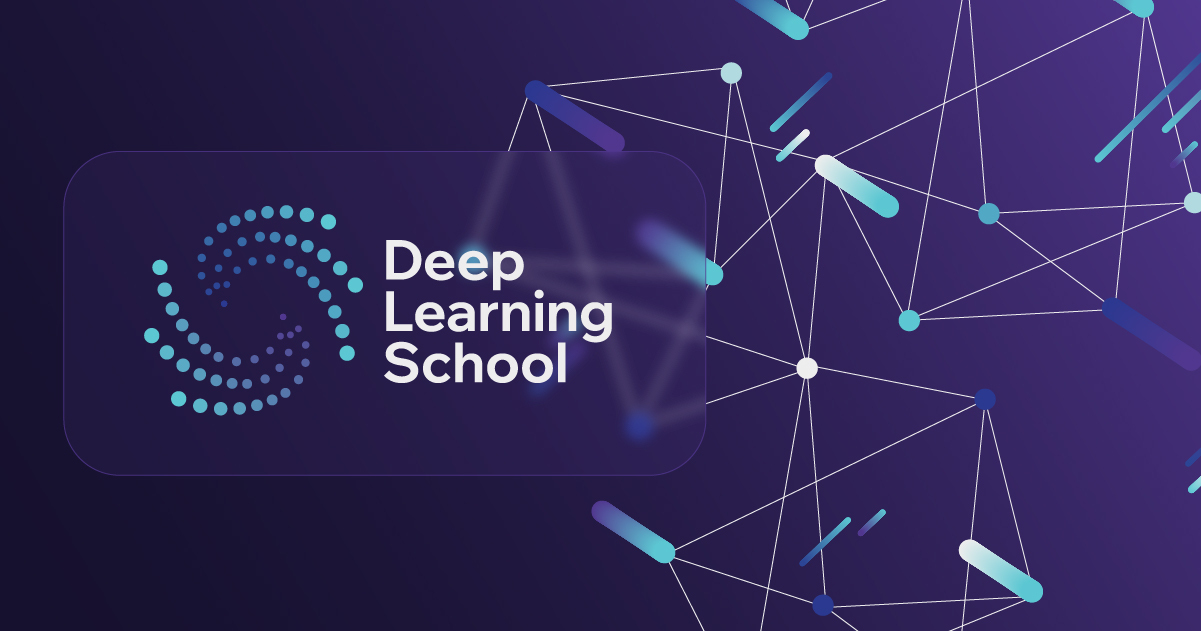


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 991 картинка, для которых вам будет необходимо предсказать класс.

## Шаг 1. Установка зависимостей

####Установим необходимые библиотеки и проверим доступность CUDA

In [131]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [132]:
!nvidia-smi

Sun Nov  9 18:56:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             29W /   70W |    8371MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [133]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


#### Проверим версии Python и библиотек
Посмотрим, какие версии установлены:

In [134]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.11.13
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.2
seaborn version: 0.12.2
Pillow version: 11.3.0


Сверим с версиями питона и библиотек, на которых работал эталонный ноутбук:

- Python 3.12.12
- torch version: 2.8.0+cu126
- torchvision version: 0.23.0+cu126
- tqdm version: 4.67.1
- matplotlib version: 3.10.0
- seaborn version: 0.13.2
- Pillow version: 11.3.0


 #### Определим константы, которые будем использовать в по ходу ноутбука

In [135]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-to-springfield1/train') #Path('./data/train/')
TEST_DIR = Path('/kaggle/input/journey-to-springfield1/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

#### Скачаем изображения по ссылке

In [120]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Downloading...
From (original): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1
From (redirected): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1&confirm=t&uuid=2e6f416f-83e6-42fd-87a6-99c4953bde54
To: /kaggle/working/journey-springfield.zip
100%|█████████████████████████████████████████| 546M/546M [00:02<00:00, 209MB/s]


In [121]:
!unzip -q /kaggle/working/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Посмотрите на структуру файлов в папках train и testset.

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок. Это полные имена, включающие путь к файлам.


In [136]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа. Зададим числовые метки классов нашего энкодера при помощи метода `fit`.

Далее будем применять метод `transform` для преобразования текстовых меток в числовые, и метод `inverse_transform` для преобразования числовых меток в текстовые.


In [137]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса.

In [138]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

####Создадим Datasets и Dataloaders

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:
https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


У нас есть набор файлов-картинок, которые требуется преобразовать в тензоры, и добавить к ним числовые метки классов. Реализуем это с помощью созданного нами класса `SimpsonsDataset`, который из списка файлов создаст необходимый нам Dataset.  

Будем действовать согласно инструкции из документации (https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files):
- наш класс будет наследовать от класса Dataset
- мы переопределим методы `__init__`, `__len__` и `__getitem__`, а также для удобства добавим несколько методов для загрузки и преобразования изображений.

Важно разобраться, что делает метод self.transform_images_to_tensors().

`Compose` объединяет последовательность следующих преобразований:
- `PILToTensor` конвертирует  `PIL Image` в тензор с параметрами в диапазоне $[0, 255]$ (как все пиксели в исходном изображении)
- `ToDtype` преобразует тензор в `FloatTensor` размера ($C \times H \times W$) со значениями пикселей в диапазоне $[0,1]$
- затем `Normalize` производится масштабирование:
$\text{input} = \frac{\text{input} - \text{mean}}{\text{std}} $, <br>      где константы mean и std - средние и дисперсии по каналам в датасете ImageNet
- наконец, `Resize` преобразует картинки к размеру $224 \times 224$ (в описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру).

Сейчас аугментация не изображений не производится, поэтому для обучающих и валидационных/тестовых изображений производится одинаковая трансформация. В дальнейшем, если вы захотите добавить аугментацию, вы можете сделать это, например, модифицировав метод `transform_images_to_tensors`. Подробнее про трансформацию изображений вы можете почитать в документации: https://docs.pytorch.org/vision/main/transforms.html


In [139]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_ # сейчас self.__len__() возвращает количество картинок, подаваемых на вход.
        # Если вы решите перевзвесить размеры категорий внутри класса -
        # не забудьте изменить вывод self.__len__()

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            v2.RandomResizedCrop(size=(RESCALE_SIZE), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
          ])
      else:
        transform = v2.Compose([
            v2.Resize(RESCALE_SIZE),    
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [140]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [141]:
batch_size = 32

In [142]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 4)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

Напишем функцию для визуализации картинок. Это аналог Imshow, которая будет принимать на вход тензоры

In [143]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 17
Текстовая метка класса: ['krusty_the_clown']


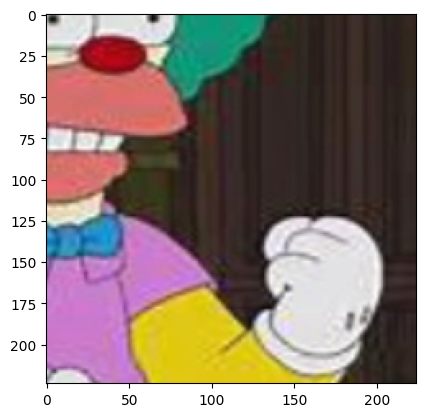

In [144]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [145]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [146]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам. Очистка датасета - это один из способов повысить качество модели. Этим можно будет заняться во второй части домашнего задания.

Запустим написанную функцию.

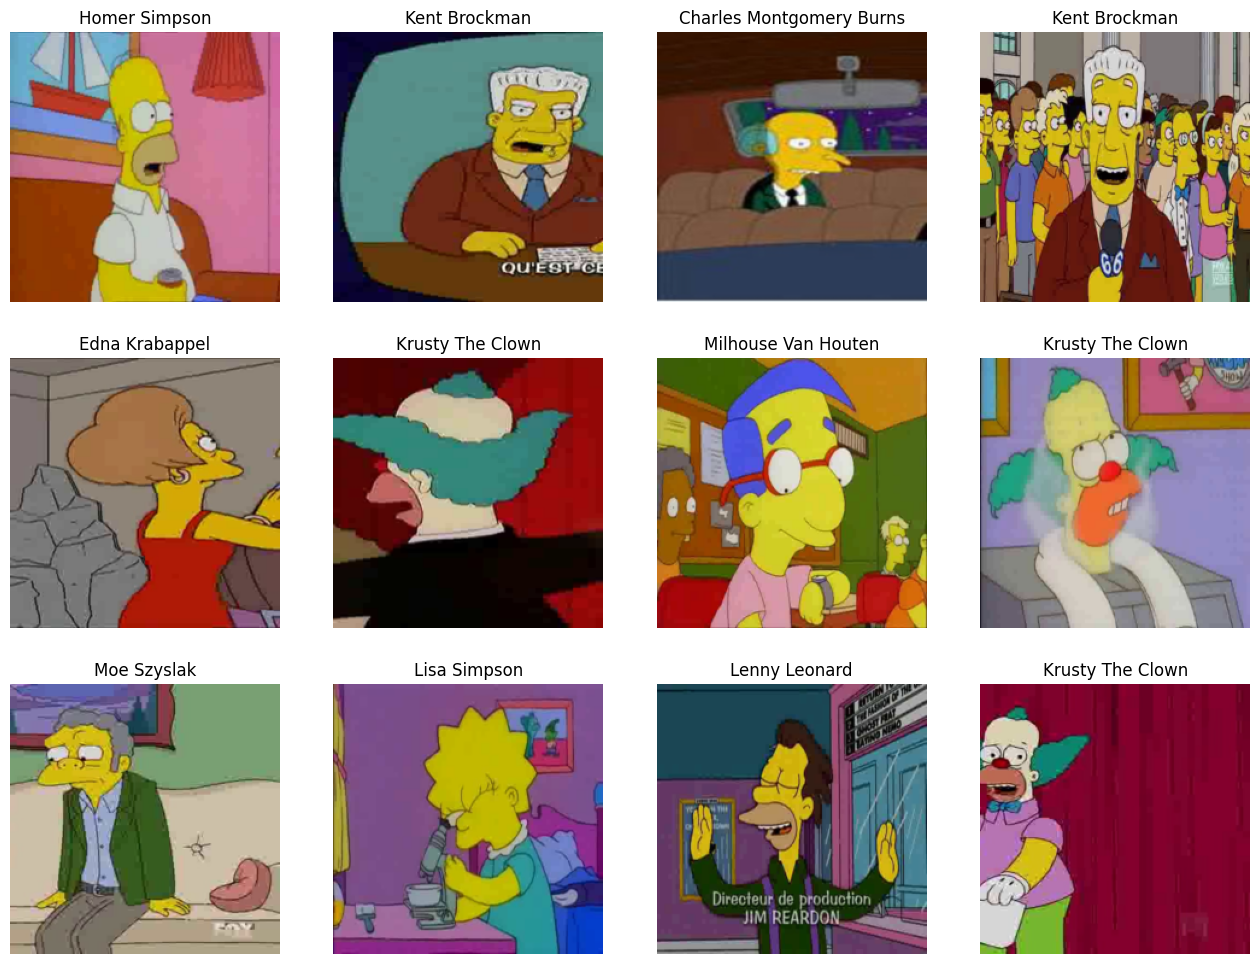

In [147]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

## Шаг 3. Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [148]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

*Описание слоев*:

1. размерность входа: $3\times 224 \times 224$
2. размерность после 1-го слоя (Conv2d + ReLU + MaxPool2d):  $8 \times 111 \times 111$
3. после 2-го слоя: $16 \times 54 \times 54$
4. после 3-го слоя: $32 \times 26 \times 26$
5. после 4-го слоя: $64 \times 12 \times 12$
6. после 5-го слоя: $96 \times 5 \times 5$
7. после полносвязного слоя (выход модели): количество классов

In [149]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

Возьмём две модель Interception

In [150]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionV4', 'inceptionv4']

pretrained_settings = {
    'inceptionv4': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_3a(nn.Module):

    def __init__(self):
        super(Mixed_3a, self).__init__()
        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.conv = BasicConv2d(64, 96, kernel_size=3, stride=2)

    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_4a(nn.Module):

    def __init__(self):
        super(Mixed_4a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 64, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 64, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 96, kernel_size=(3,3), stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_5a(nn.Module):

    def __init__(self):
        super(Mixed_5a, self).__init__()
        self.conv = BasicConv2d(192, 192, kernel_size=3, stride=2)
        self.maxpool = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        out = torch.cat((x0, x1), 1)
        return out


class Inception_A(nn.Module):

    def __init__(self):
        super(Inception_A, self).__init__()
        self.branch0 = BasicConv2d(384, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(384, 96, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_A(nn.Module):

    def __init__(self):
        super(Reduction_A, self).__init__()
        self.branch0 = BasicConv2d(384, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=3, stride=1, padding=1),
            BasicConv2d(224, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_B(nn.Module):

    def __init__(self):
        super(Inception_B, self).__init__()
        self.branch0 = BasicConv2d(1024, 384, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 224, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(224, 256, kernel_size=(1,7), stride=1, padding=(0,3))
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1024, 128, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_B(nn.Module):

    def __init__(self):
        super(Reduction_B, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(256, 320, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_C(nn.Module):

    def __init__(self):
        super(Inception_C, self).__init__()

        self.branch0 = BasicConv2d(1536, 256, kernel_size=1, stride=1)

        self.branch1_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch1_1a = BasicConv2d(384, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch1_1b = BasicConv2d(384, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch2_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch2_1 = BasicConv2d(384, 448, kernel_size=(3,1), stride=1, padding=(1,0))
        self.branch2_2 = BasicConv2d(448, 512, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3a = BasicConv2d(512, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3b = BasicConv2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1536, 256, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)

        x1_0 = self.branch1_0(x)
        x1_1a = self.branch1_1a(x1_0)
        x1_1b = self.branch1_1b(x1_0)
        x1 = torch.cat((x1_1a, x1_1b), 1)

        x2_0 = self.branch2_0(x)
        x2_1 = self.branch2_1(x2_0)
        x2_2 = self.branch2_2(x2_1)
        x2_3a = self.branch2_3a(x2_2)
        x2_3b = self.branch2_3b(x2_2)
        x2 = torch.cat((x2_3a, x2_3b), 1)

        x3 = self.branch3(x)

        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionV4(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionV4, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.features = nn.Sequential(
            BasicConv2d(3, 32, kernel_size=3, stride=2),
            BasicConv2d(32, 32, kernel_size=3, stride=1),
            BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            Mixed_3a(),
            Mixed_4a(),
            Mixed_5a(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Reduction_A(), # Mixed_6a
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Reduction_B(), # Mixed_7a
            Inception_C(),
            Inception_C(),
            Inception_C()
        )
        self.last_linear = nn.Linear(1536, num_classes)

    def logits(self, features):
        #Allows image of any size to be processed
        adaptiveAvgPoolWidth = features.shape[2]
        x = F.avg_pool2d(features, kernel_size=adaptiveAvgPoolWidth)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def inceptionv4(num_classes=1000, pretrained='imagenet'):
    if pretrained:
        settings = pretrained_settings['inceptionv4'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionV4(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionV4(num_classes=num_classes)
    return model


In [151]:
model = inceptionv4(num_classes=1000, pretrained='imagenet')  # или 1001 для imagenet+background

n_classes = len(np.unique(train_val_labels))
last_fc = nn.Linear(1536, n_classes)

nn.init.kaiming_normal_(model.last_linear.weight)
if last_fc.bias is not None:
    nn.init.constant_(last_fc.bias, 0)

model.last_linear = last_fc


In [152]:
model = torch.nn.DataParallel(model)
model.to("cuda")

DataParallel(
  (module): InceptionV4(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed_3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Conv2d(64, 96, kernel_size=(3, 3), stri

##Шаг 4. Функции для работы с моделью

#### Задание - напишите функции для работы с моделью

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Ниже приводится код для вычисления целевой метрики.

In [153]:
from sklearn.metrics import f1_score
# пример расчета: f1 = f1_score(actual_labels, y_predicted, average='micro')

В этом задании может быть полезным сделать, чтобы функция валидации и, возможно, функция обучения на одной эпохе возвращали векторы/тензоры:
- предсказанного наиболее вероятного класса
- и фактических меток класса для каждого объекта.

Сама метрика f1, при этом, будет вычисляться не внутри функции, а вне ее, сопоставляя прогнозные и фактические значения, полученные из вывода функции.

Это поможет проанализировать, при предсказании каких классов модель ошибается чаще. Также такой подход может использоваться для обнаружения изображений, которые модель классифицирует неверно.

Для ускорения вычислений рекомендуется при работе с моделью проводить тензорные вычисления на GPU. Обращаем внимание, для этого необходимо, чтобы и данные, и модель находились на одном устройстве.

Ниже представлен код из предыдущего домашнего задания, который демонстрировал логику циклов обучения и валидации. Ниже в этот код добавлены строки комментарии, показывающие как переносить модель и данные на устройство.


```python
model.to(DEVICE)  # <- переносим модель на устройство DEVICE

for epoch in range(max_epochs):  
    # режим train
    model.train()  
    for x_batch, y_batch in train_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        optimizer.zero_grad()
        outp = model(x_batch)
        loss = criterion(outp, y_batch)
        loss.backward()  
        optimizer.step()
        
        count_metrics(outp, y_batch)  # <-здесь, скорее всего, потребуется перенести данные на cpu, например с помощью метода cpu: metrics.cpu()
     
     # режим test/eval
     model.eval()  
     for x_batch, y_batch in val_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        with torch.no_grad():
            outp = model(x_batch)
            count_metrics(outp, y_batch) # <-здесь, скорее всего, потребуется перенести данные на cpu       
```

Напишите функции:
- для обучения модели на одной эпохе
- для валидации модели на одной эпохе
- для реализации полного цикла обучения

За основу можно взять функции, которые вы написали в предыдущем домашнем задании.

In [154]:
from sklearn.metrics import f1_score
# пример расчета: f1 = f1_score(actual_labels, y_predicted, average='micro')

def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  model.train()

  actual_labels = []
  y_predicted = []


  for X_batch, y_batch in tqdm(train_dataloader):
    # Далее далее по коду идут стандартные операции цикла обучения:
    X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda") # Move data to device
    outp = model(X_batch)
    loss = loss_func(outp, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    preds = outp.argmax(-1)
    actual_labels.append(y_batch.cpu().numpy()) # Convert tensor to numpy array
    y_predicted.append(preds.cpu().numpy()) # Convert tensor to numpy array

  actual_labels = np.concatenate(actual_labels) # Concatenate numpy arrays
  y_predicted = np.concatenate(y_predicted) # Concatenate numpy arrays
  f1 = f1_score(actual_labels, y_predicted, average='micro')
  return f1

In [155]:
def eval_one_epoch(model, val_dataloader):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''

  model.eval()

  actual_labels = []
  y_predicted = []

  with torch.no_grad():
    for X_batch, y_batch in tqdm(val_dataloader):
      # Далее далее по коду идут стандартные операции цикла валидации:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda") # Move data to device
        outp = model(X_batch)
        preds = outp.argmax(-1)

        actual_labels.append(y_batch.cpu().numpy()) # Convert tensor to numpy array
        y_predicted.append(preds.cpu().numpy()) # Convert tensor to numpy array

  actual_labels = np.concatenate(actual_labels) # Concatenate numpy arrays
  y_predicted = np.concatenate(y_predicted) # Concatenate numpy arrays
  f1 = f1_score(actual_labels, y_predicted, average='micro')
  return f1

In [156]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  f1 = {"train": [], "valid": []}
  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    f1_train_one_epoch = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
    print(f"f1_train: {f1_train_one_epoch}\n")

    f1_test_one_epoch = eval_one_epoch(model = model, val_dataloader = dataloaders['val'])
    print(f"f1_test: {f1_test_one_epoch}\n")

    f1['train'].append(f1_train_one_epoch)
    f1['valid'].append(f1_test_one_epoch)
  return f1

## Шаг 5. Применение модели к данным

#### Применение модели к данным

In [157]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

Запустите обучение сети

In [158]:
scores = train_func(model, 20, loaders, optimizer, criterion)


Epoch: 1


100%|██████████| 491/491 [03:15<00:00,  2.51it/s]


f1_train: 0.6552646665392701



100%|██████████| 164/164 [00:32<00:00,  5.08it/s]


f1_test: 0.8446694688574705


Epoch: 2


100%|██████████| 491/491 [03:18<00:00,  2.48it/s]


f1_train: 0.7701127460347793



100%|██████████| 164/164 [00:31<00:00,  5.13it/s]


f1_test: 0.9172716851356515


Epoch: 3


100%|██████████| 491/491 [03:18<00:00,  2.47it/s]


f1_train: 0.7947002993821263



100%|██████████| 164/164 [00:31<00:00,  5.16it/s]


f1_test: 0.9277799006495988


Epoch: 4


100%|██████████| 491/491 [03:17<00:00,  2.49it/s]


f1_train: 0.8184597745079304



100%|██████████| 164/164 [00:31<00:00,  5.20it/s]


f1_test: 0.9159342758884219


Epoch: 5


100%|██████████| 491/491 [03:17<00:00,  2.49it/s]


f1_train: 0.8257213835276133



100%|██████████| 164/164 [00:31<00:00,  5.18it/s]


f1_test: 0.9363775315246465


Epoch: 6


100%|██████████| 491/491 [03:17<00:00,  2.49it/s]


f1_train: 0.8362953054334671



100%|██████████| 164/164 [00:31<00:00,  5.16it/s]


f1_test: 0.9180359189912114


Epoch: 7


100%|██████████| 491/491 [03:16<00:00,  2.50it/s]


f1_train: 0.8395439199949042



100%|██████████| 164/164 [00:32<00:00,  5.10it/s]


f1_test: 0.9411539931218953


Epoch: 8


100%|██████████| 491/491 [03:16<00:00,  2.50it/s]


f1_train: 0.8489712720555449



100%|██████████| 164/164 [00:31<00:00,  5.17it/s]


f1_test: 0.9466946885747038


Epoch: 9


100%|██████████| 491/491 [03:16<00:00,  2.49it/s]


f1_train: 0.846996623988789



100%|██████████| 164/164 [00:31<00:00,  5.18it/s]


f1_test: 0.9430645777607948


Epoch: 10


100%|██████████| 491/491 [03:15<00:00,  2.51it/s]


f1_train: 0.8550226129052806



100%|██████████| 164/164 [00:31<00:00,  5.18it/s]


f1_test: 0.9486052732136033


Epoch: 11


100%|██████████| 491/491 [03:16<00:00,  2.50it/s]


f1_train: 0.8584623224409198



100%|██████████| 164/164 [00:32<00:00,  5.12it/s]


f1_test: 0.9493695070691631


Epoch: 12


100%|██████████| 491/491 [03:17<00:00,  2.49it/s]


f1_train: 0.8600547805592713



100%|██████████| 164/164 [00:31<00:00,  5.28it/s]


f1_test: 0.945930454719144


Epoch: 13


100%|██████████| 491/491 [03:15<00:00,  2.51it/s]


f1_train: 0.8624116185744315



100%|██████████| 164/164 [00:31<00:00,  5.20it/s]


f1_test: 0.9520443255636225


Epoch: 14


100%|██████████| 491/491 [03:18<00:00,  2.47it/s]


f1_train: 0.8654054398369323



100%|██████████| 164/164 [00:32<00:00,  5.12it/s]


f1_test: 0.96159724875812


Epoch: 15


100%|██████████| 491/491 [03:17<00:00,  2.49it/s]


f1_train: 0.8675074845531563



100%|██████████| 164/164 [00:31<00:00,  5.27it/s]


f1_test: 0.9510890332441727


Epoch: 16


100%|██████████| 491/491 [03:15<00:00,  2.52it/s]


f1_train: 0.8704376074909229



100%|██████████| 164/164 [00:31<00:00,  5.24it/s]


f1_test: 0.9528085594191823


Epoch: 17


100%|██████████| 491/491 [03:14<00:00,  2.52it/s]


f1_train: 0.8716478756608701



100%|██████████| 164/164 [00:30<00:00,  5.33it/s]


f1_test: 0.9457393962552542


Epoch: 18


100%|██████████| 491/491 [03:14<00:00,  2.53it/s]


f1_train: 0.8755334734696477



100%|██████████| 164/164 [00:31<00:00,  5.28it/s]


f1_test: 0.9503247993886129


Epoch: 19


100%|██████████| 491/491 [03:13<00:00,  2.54it/s]


f1_train: 0.8765526466653927



100%|██████████| 164/164 [00:30<00:00,  5.35it/s]


f1_test: 0.9556744363775316


Epoch: 20


100%|██████████| 491/491 [03:12<00:00,  2.55it/s]


f1_train: 0.8798649595515637



100%|██████████| 164/164 [00:30<00:00,  5.46it/s]

f1_test: 0.9594956056553305



(опционально) Постройте график динамики метрик модели по ходу обучения

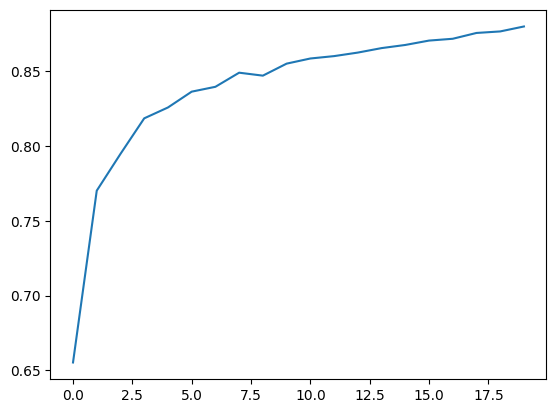

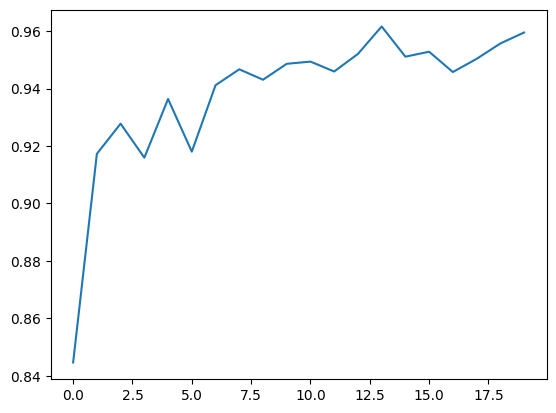

In [174]:
plt.plot((range(20)), scores['train'])
plt.show()
plt.plot((range(20)), scores['valid'])

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

In [175]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # выводим изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()

    # ниже представлен код для добавления на изображение подписи с вероятностью класса
    actual_text = "Actual : {}".format(img_label)


    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100 # берем максимальную вероятность класса
    y_pred = np.argmax(prob_pred) # берем числовую метку класса, для которого вероятность максимальна

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

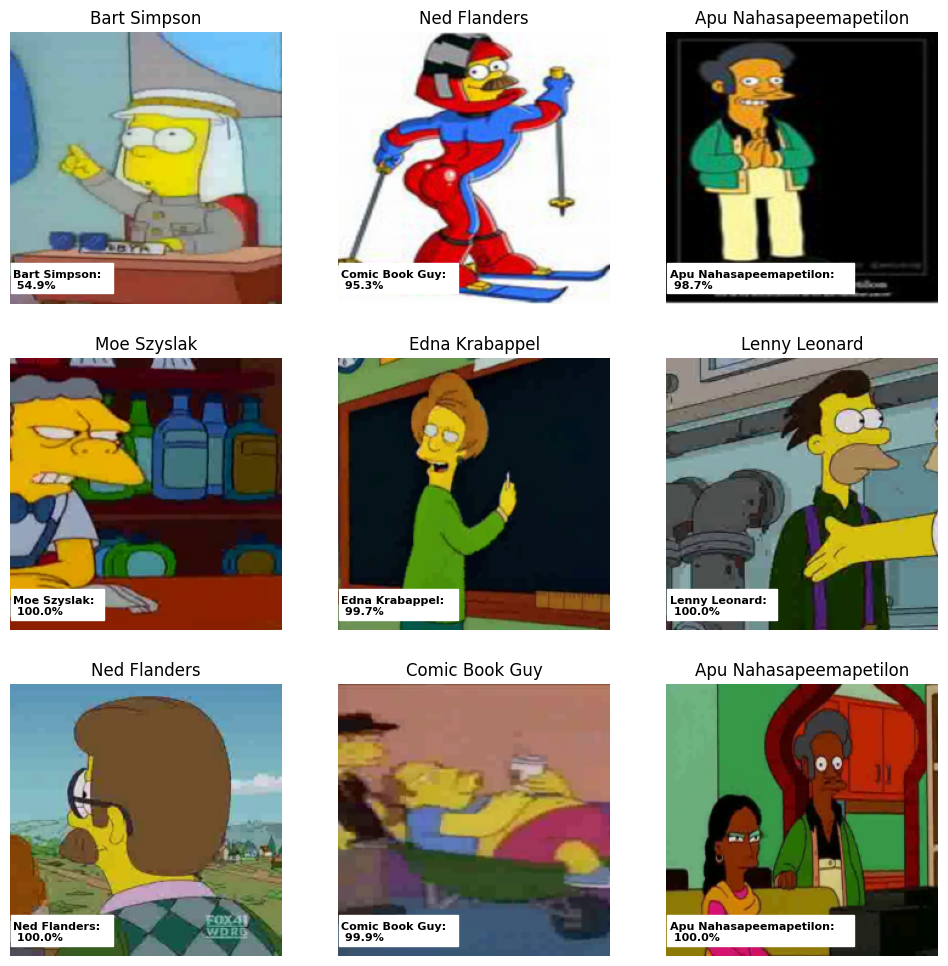

In [176]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = model)

## Шаг 6. Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

Создадим loader для тестовых данных

In [177]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

Воспользуемся функцией predict, которая возвращает предсказанные числовые метки для всех объектов в лоадере.

In [178]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

Получем предсказание меток классов для тестовых данных:

In [179]:
predicted_numeric_labels = predict(model, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

и преобразуем их в текстовые метки:

In [180]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

Загрузим пример файла для загрузки на Kaggle (проверьте путь, по которому у вас лежит файл sample_submission.csv и при необходимости скорректируйте путь в коде ниже):

In [181]:
import pandas as pd
sample_submission = pd.read_csv('/kaggle/input/journey-to-springfield1/sample_submission.csv')
sample_submission.head(10)

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson
5,img5.jpg,bart_simpson
6,img6.jpg,bart_simpson
7,img7.jpg,bart_simpson
8,img8.jpg,bart_simpson
9,img9.jpg,bart_simpson


In [182]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [168]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [184]:
my_submission.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся score нас явно не устраивает. Надо с этим что-то сделать.

Вам предлагается творческая и исследовательская свобода в том, как вы будете улучшать score модели. Вот некоторые направления, которые вы, возможно, захотите попробовать:
1. Работа с датасетом:
* Попробуйте увеличить разнообразие обучающей выборки при помощи аугментации ([ссылка 1](https://habr.com/ru/companies/smartengines/articles/264677/), [ссылка 2](https://www.geeksforgeeks.org/python-data-augmentation/));
* Используя результаты функции eval_one_epoch, вы можете посмотреть, как метрика f1-score внутри класса связана с размером самого класса в обучающей выборке. Скорее всего, вы заметите прямую зависимость. Решением может быть увеличение размеров слабо представленных классов. Сделать это можно, вручную добавив этот функционал в SimpsonsDataset или воспользовавшись инструментом WeightedRandomSampler.

* Также вы можете изучить, какие изображения модель классифицирует неверно. Можно просто посмотреть неверно классифицированные изображения в валидационном датасете. Можно попробовать более фундаментальный подход - создать dataloader из всех изображений обучающей и валидационной выборки в SimpsonsDataset c режимом 'val', прогнать данные через обученную модель simple_cnn. Более того, можно обучить несколько моделей с разной архитектурой, и прогнать объединенный датасет через все эти модели - и выделить те изображения, в классификации которых ошиблись несколько моделей.

* Это поможет понять, как качество и чистота исходных данных влияет на результаты обучения модели. Если вы обнаружите ошибки в simpsons_dataset и решите их исправить или удалить некоторые изображения из обучающей выборки - сделайте это в ноутбуке, чтобы при проверке можно было повторить результаты работы вашего кода.  

2. Работа с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных и полносвязных слоёв;
* А еще есть где пулинги и батч-норм!

3. Применение техник, описанных в предыдущих пунктах, позволяет добиться довольно высоких результатов. Но вы можете попробовать файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

4. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

5. Наконец, возможно, стоит подумать об ансамблях


Надеюсь, что у Вас получится!

Score: 0.96811
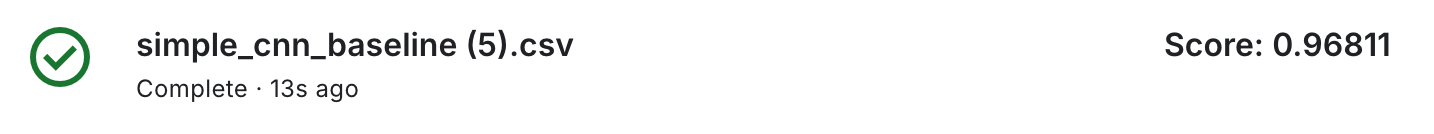

Ник на kaggle: Гущин_Денис_933779567

Поставьте 15 пжпжпжп)))) на 0.002 не сошлась метрика